In [1]:
!pip install torch

   ---------------------------------------- 0.0/159.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/159.8 MB 1.3 MB/s eta 0:02:05
   ---------------------------------------- 0.1/159.8 MB 1.1 MB/s eta 0:02:21
   ---------------------------------------- 0.2/159.8 MB 1.4 MB/s eta 0:01:55
   ---------------------------------------- 0.3/159.8 MB 1.8 MB/s eta 0:01:31
   ---------------------------------------- 0.5/159.8 MB 2.3 MB/s eta 0:01:11
   ---------------------------------------- 0.9/159.8 MB 3.6 MB/s eta 0:00:45
   ---------------------------------------- 1.2/159.8 MB 3.7 MB/s eta 0:00:44
    --------------------------------------- 2.0/159.8 MB 5.8 MB/s eta 0:00:28
    --------------------------------------- 2.0/159.8 MB 5.8 MB/s eta 0:00:28
    --------------------------------------- 2.5/159.8 MB 5.8 MB/s eta 0:00:28
    --------------------------------------- 2.6/159.8 MB 5.6 MB/s eta 0:00:29
    --------------------------------------- 2.6/159.8 MB 5.6 MB/s eta 0

In [2]:
import torch
!pip install opencv-python

  Using cached opencv_python-4.10.0.82-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.10.0.82-cp37-abi3-win_amd64.whl (38.8 MB)


In [4]:
!pip install scikit-learn

In [42]:
import numpy as np
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2  #separating RGB channels from the images

In [60]:
#pre-processing to make all the images of same size

tumor = []
path = './data/BrainDis_dataset/yes/*.jpg'
for x in glob.iglob(path):
    img = cv2.imread(x)
    img = cv2.resize(img, (120,120))
    b,g,r = cv2.split(img)
    img = cv2.merge([r,g,b])
    tumor.append(img)


healthy = []
path = './data/BrainDis_dataset/no/*.jpg'
for x in glob.iglob(path2):
    img = cv2.imread(x)
    img = cv2.resize(img, (120,120))
    b,g,r = cv2.split(img)
    img = cv2.merge([r,g,b])
    healthy.append(img)

len(healthy)

91

In [61]:
healthy = np.array(healthy)
tumor = np.array(tumor)
All = np.concatenate((healthy,tumor))
healthy.shape
len(All)

245

In [68]:
#visualizing 
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1,num,i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])

    for i in range(num):
        plt.subplot(2,num,i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])



    

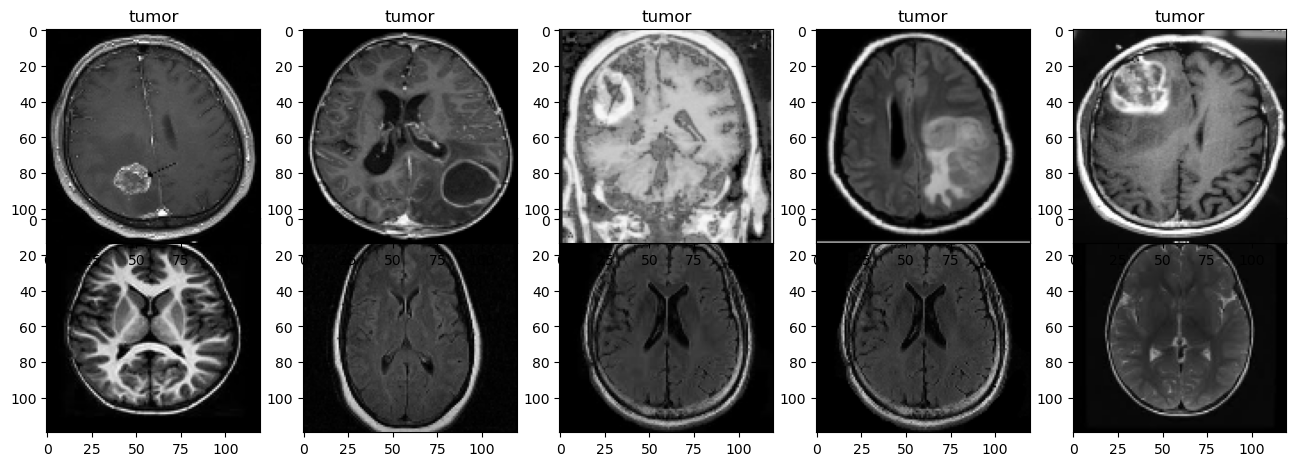

In [69]:
plot_random(healthy, tumor)

In [64]:
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

In [70]:
class MRI(Dataset):
    def __init__(self):
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./data/BrainDis_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./data/BrainDis_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, index):
        
        sample = {'image': self.images[index], 'label':self.labels[index]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

In [82]:
mri_dataset = MRI()
mri_dataset.normalize()

In [84]:
len(mri_dataset)

245

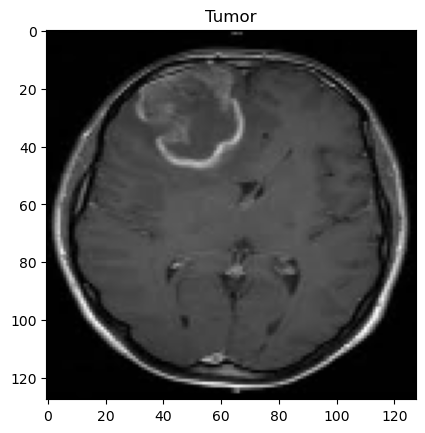

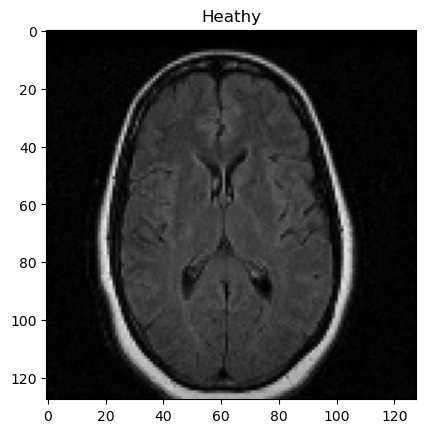

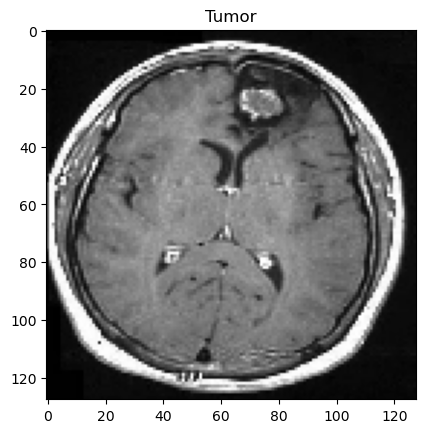

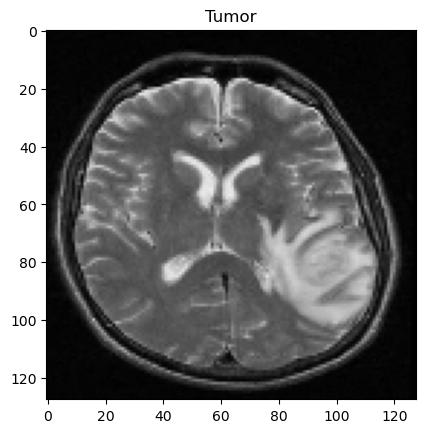

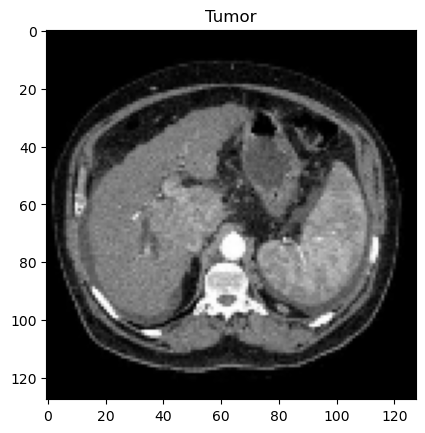

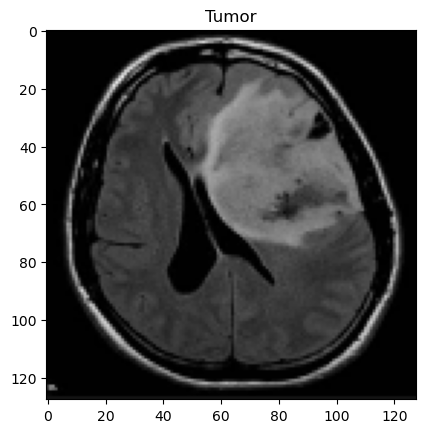

In [85]:
# One way of iterating
names={0:'Heathy', 1:'Tumor'}
dataloader = DataLoader(mri_dataset, shuffle=True)
for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()
    img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    plt.show()
    if i == 5:
        break

In [86]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))
        
        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)
        
        return x

In [87]:
device = torch.device('cpu')
model = CNN().to(device)

In [88]:
#Training the model
eta = 0.0001 #learning rate
EPOCH=400
optimizer = torch.optim.Adam(model.parameters(), lr=eta) 
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()


CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [102]:
for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        # define loss function
        error = nn.BCELoss() 
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

Train Epoch: 10	Loss: 0.009057
Train Epoch: 20	Loss: 0.007331
Train Epoch: 30	Loss: 0.006477
Train Epoch: 40	Loss: 0.005727
Train Epoch: 50	Loss: 0.005097
Train Epoch: 60	Loss: 0.004441
Train Epoch: 70	Loss: 0.004050
Train Epoch: 80	Loss: 0.003524
Train Epoch: 90	Loss: 0.003410
Train Epoch: 100	Loss: 0.002907
Train Epoch: 110	Loss: 0.002655
Train Epoch: 120	Loss: 0.002492
Train Epoch: 130	Loss: 0.002225
Train Epoch: 140	Loss: 0.002007
Train Epoch: 150	Loss: 0.001874
Train Epoch: 160	Loss: 0.001772
Train Epoch: 170	Loss: 0.001602
Train Epoch: 180	Loss: 0.001459
Train Epoch: 190	Loss: 0.001339
Train Epoch: 200	Loss: 0.001235
Train Epoch: 210	Loss: 0.001136
Train Epoch: 220	Loss: 0.001068
Train Epoch: 230	Loss: 0.000975
Train Epoch: 240	Loss: 0.000933
Train Epoch: 250	Loss: 0.000840
Train Epoch: 260	Loss: 0.000786
Train Epoch: 270	Loss: 0.000753
Train Epoch: 280	Loss: 0.000707
Train Epoch: 290	Loss: 0.000663
Train Epoch: 300	Loss: 0.000613
Train Epoch: 310	Loss: 0.000561
Train Epoch: 320	

In [103]:
#evaluating the model

model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad():
    for D in dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(image)
        
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
        
outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

In [104]:
accuracy_score(y_true, threshold(outputs))


1.0

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

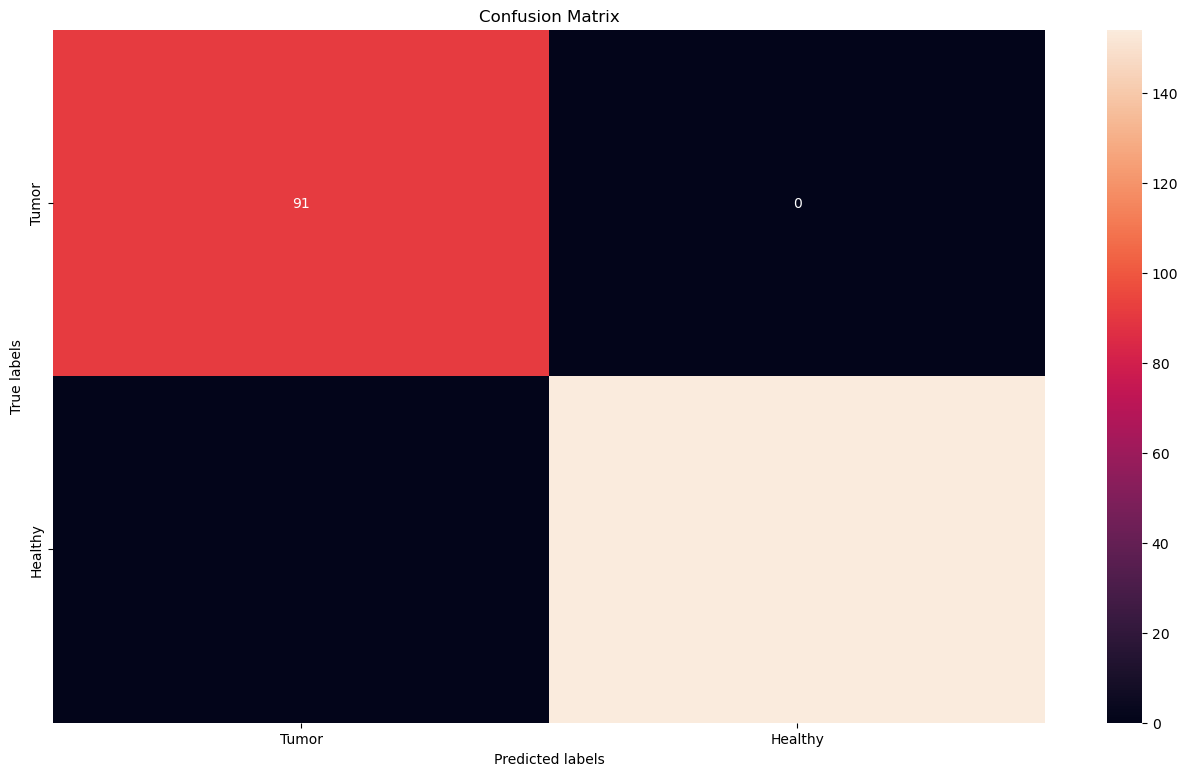

In [105]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

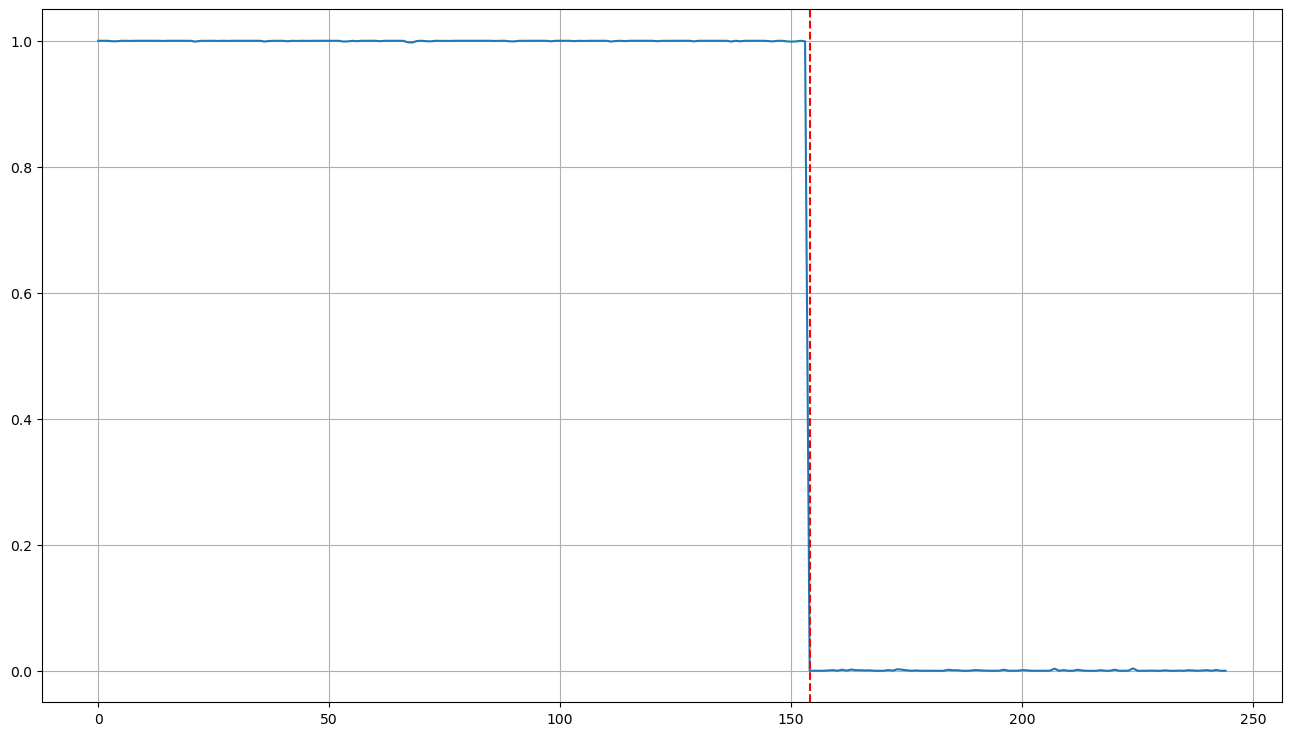

In [107]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

In [108]:
model


CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [109]:
no_of_layers = 0
conv_layers = []

In [110]:
model_children = list(model.children())
model_children

[Sequential(
   (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
   (1): Tanh()
   (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
   (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (4): Tanh()
   (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
 ),
 Sequential(
   (0): Linear(in_features=256, out_features=120, bias=True)
   (1): Tanh()
   (2): Linear(in_features=120, out_features=84, bias=True)
   (3): Tanh()
   (4): Linear(in_features=84, out_features=1, bias=True)
 )]

In [111]:
for child in model_children:
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                no_of_layers += 1
                conv_layers.append(layer)

In [112]:
conv_layers

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))]

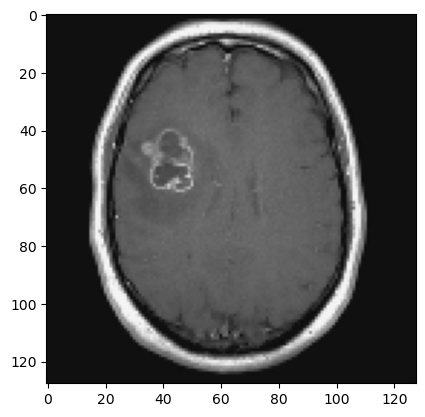

In [113]:

img = mri_dataset[89]['image']
plt.imshow(img.reshape(128,128,3))

In [114]:
img = torch.from_numpy(img).to(device)